# Classifier Model Training

### Train basic models (Tweets' textual data) & an advanced model with metadata used as additional features.
### Perform GridSearch Cross Validation to tune hyperparameters and retrain models to achieve a better score.
#### `Python 3.9.9`

In [100]:
import pandas as pd
import numpy as np
import en_core_web_sm
from spacymoji import Emoji

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Model Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation Metrics Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from joblib import dump

Load preprocessed data and create datasets of each class with equal numbers of spam/not-spam tweets.

In [101]:
content_polluters_tweets_df = pd.read_csv('../Data/content_polluters_tweets_pp.csv')
legitimate_users_tweets_df = pd.read_csv('../Data/legitimate_users_tweets_pp.csv')

tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)
content_polluters_tweets_df = tweets_df.head(len(content_polluters_tweets_df)).tail(len(legitimate_users_tweets_df))
legitimate_users_tweets_df = tweets_df.tail(len(legitimate_users_tweets_df))
tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)



# Display dataset's statistics
print("Spam tweets:", len(content_polluters_tweets_df))
print("Normal tweets:", len(legitimate_users_tweets_df))
print("Total tweets:", len(tweets_df))

# Testing
try:
    assert isinstance(content_polluters_tweets_df, pd.DataFrame), "Content Polluters' tweets must be a Pandas DataFrame."
    assert isinstance(legitimate_users_tweets_df, pd.DataFrame), "Legitimate Users' tweets must be a Pandas DataFrame."
    assert content_polluters_tweets_df.shape == legitimate_users_tweets_df.shape, "Content Polluters' tweets and Legitimate Users' tweets dataframes must be of identical shapes."
    assert len(content_polluters_tweets_df[content_polluters_tweets_df["Tweet"] == str(np.nan)]) == 0, "Content Polluters' tweets dataset must not contain empty (np.nan) tweets."
    assert len(legitimate_users_tweets_df[legitimate_users_tweets_df["Tweet"] == str(np.nan)]) == 0, "Legitimate Users' tweets dataset must not contain empty (np.nan) tweets."
except AssertionError as a:
    print(a)

Spam tweets: 7872
Normal tweets: 7872
Total tweets: 15744


***
## Model Training and Evaluation method definitions
>### - `split`(`tweets_df`):
>Splits the dataset into `training` (`60%`), `validation` (`20%`) and `test` (`20%`) data, and returns the lowered Tweet text and their label.

In [102]:
def split(tweets_df):
    # Input Testing
    try:
        assert isinstance(tweets_df, pd.DataFrame), "Input must be a Pandas DataFrame."
    except AssertionError as a:
        print(a)
    
    X_train, X_test, y_train, y_test = train_test_split(tweets_df['Tweet'], tweets_df['Spam'], test_size=0.2, random_state=0)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    
    X_train = X_train.str.lower()
    X_val = X_val.str.lower()
    X_test = X_test.str.lower()
    
    # Output Testing
    try:
        assert len(X_train) + len(X_val) + len(X_test) == len(tweets_df), "Split data must be of identical length to input dataset."
        assert len(X_train) + len(X_val) + len(X_test) == len(tweets_df), "Split labels must be of identical length to input dataset."
        assert len(X_train) == len(y_train), "Training data and labels must be of equal lengths."
        assert len(X_val) == len(y_val), "Validation data and labels must be of equal lengths."
        assert len(X_test) == len(y_test), "Test data and labels must be of equal lengths."
    except AssertionError as a:
        print(a)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

>### - `evaluation_summary`(`description`, `predictions`, `true_labels`):
>Returns an evaluation summary of the model, with macro evaluation metrics and a confusion matrix.

In [103]:
# Evaluation summary model
def evaluation_summary(description, predictions, true_labels):

  # Input Testing
  try:
    assert isinstance(description, str), "Description must be a string."
    assert isinstance(predictions, pd.Series), "Predictions must be a Pandas Series."
    assert isinstance(true_labels, pd.Series), "True labels must be a Pandas Series."
  except AssertionError as a:
    print(a)
  
  print("\nMacro-averaged evaluation for:", description)
  
  # Calculate evaluation metrics
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = f1_score(predictions, true_labels, average='macro')
  
  # Print metrics to 3 decimal places
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f\n" % (description,accuracy,precision,recall,f1))
  
  # Print classification report for all metrics to 3 decimal places
  print(classification_report(predictions, true_labels, digits=3, zero_division = 0))
    
  # Print confusion matrix to 3 decimal places
  print('\nConfusion matrix:')
  ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=['Not Spam', 'Spam'])

***
>### - `grid_search`(`pipeline`, `train_data`, `params`):
>Generic grid search method to return best model hyperparameters for the best scoring iteration in macro F1 score.

In [104]:
def grid_search(pipeline, train_data, params):
        
    # Input Testing
    try:
        assert isinstance(pipeline, Pipeline), "Pipeline must be a SKLearn Pipeline."
        assert isinstance(train_data, tuple), "Training data must be a length 2 tuple of Pandas Series."
        assert isinstance(params, dict), "Parameters must be a Pandas Dictionary."
    except AssertionError as a:
        print(a)
       
    # Define grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs=8, verbose=1, scoring='f1_macro', cv=2, error_score='raise')
    print("Performing grid search...")
    print("Pipeline:", [name for name, _ in pipeline.steps])
    print("Parameters:")
    print(params)
    X_train, y_train = train_data
    grid_search.fit(X_train, y_train)

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters

# Define c_values parameter
c_values = []
for power in range(-3,6):
  c_values.append(10**power)

***
## Natural Language Processing and text preprocessing Method Definitions
>### - `custom_tokenize`(`string`):
>Splits the string into tokens using SpaCy's custom NLP tokenization. Removes emoji, stop-word, numeric and URL tokens.
***
>### - `custom_normalize`(`tokens`):
>Takes a list of tokens, lowers and lemmatizes them, and joins them into a string.
***
>### - `custom_tokenize_normalize`(`string`):
>Performs custom tokenization and normalization on a string.

In [105]:
nlp = en_core_web_sm.load()
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)

# Custom Tokenize
def custom_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    # Ignore emojis, stop-words and numerical tokens
    if not (token._.is_emoji or token.is_stop or token.like_num or token.like_url):
      tokens.append(token)
  return tokens

# Custom Normalize
def custom_normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    # Lower token and lemmatize if not a pronoun
    normalized = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
    normalized_tokens.append(normalized)
  return ' '.join(normalized_tokens)

# Custom Tokenize and normalize
def custom_tokenize_normalize(string):
  return custom_normalize(custom_tokenize(string))

***
# Basic Models
#### (Logistic Regression, K-Nearest Neighbors, Support Vector Machine, Multinomial Naive Bayes, Decision Tree)

## Logistic Regression
### Basic LR with TF-IDF vectorization

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.6s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: LR TF-IDF
Classifier 'LR TF-IDF' has Acc=0.876 P=0.876 R=0.876 F1=0.876

              precision    recall  f1-score   support

       False      0.880     0.876     0.878      1598
        True      0.873     0.877     0.875      1551

    accuracy                          0.876      3149
   macro avg      0.876     0.876     0.876      3149
weighted avg      0.876     0.876     0.876      3149


Confusion matrix:


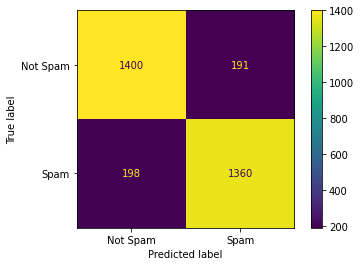

In [106]:
# Base Logistic Regression with TF-IDF vectorization
basic_p_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(n_jobs=-1, verbose=True)),
],verbose=True)

lr_tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)
lr_X_train, lr_y_train, lr_X_val, lr_y_val, lr_X_test, lr_y_test = split(lr_tweets_df)

basic_p_lr_tfidf_m = basic_p_lr_tfidf.fit(lr_X_train, lr_y_train)
dump(basic_p_lr_tfidf_m, '../Models/Basic/p_lr_tfidf_m.joblib')
evaluation_summary("LR TF-IDF", basic_p_lr_tfidf_m.predict(lr_X_test), lr_y_test)

### Basic LR TF-IDF Grid Search

In [107]:
# Set parameters dictionary
lr_params = {
   'tfidf__sublinear_tf': (True, False),
   'lr__C': (c_values)
}

basic_p_lr_tfidf_params = grid_search(basic_p_lr_tfidf, (lr_X_val, lr_y_val), lr_params)

Performing grid search...
Pipeline: ['tfidf', 'lr']
Parameters:
{'tfidf__sublinear_tf': (True, False), 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.3s
Best score: 0.824
Best parameters set:
	lr__C: 100
	tfidf__sublinear_tf: True


### Basic LR TF-IDF with Tuned Hyperparameters

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.5s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: LR TF-IDF
Classifier 'LR TF-IDF' has Acc=0.906 P=0.906 R=0.906 F1=0.906

              precision    recall  f1-score   support

       False      0.907     0.906     0.907      1592
        True      0.904     0.905     0.905      1557

    accuracy                          0.906      3149
   macro avg      0.906     0.906     0.906      3149
weighted avg      0.906     0.906     0.906      3149


Confusion matrix:


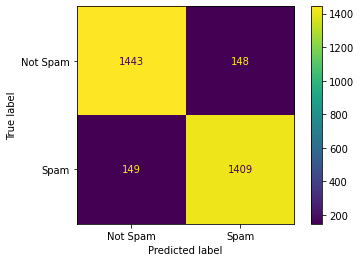

In [108]:
best_p_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('lr', LogisticRegression(n_jobs=-1, verbose=True, C=100)),
],verbose=True)

final_lr_X_train = lr_X_train.append(lr_X_val)
final_lr_y_train = lr_y_train.append(lr_y_val)

best_p_lr_tfidf_m = best_p_lr_tfidf.fit(final_lr_X_train, final_lr_y_train)
dump(best_p_lr_tfidf_m, '../Models/Basic/p_lr_tfidf_m.joblib')
evaluation_summary("LR TF-IDF", best_p_lr_tfidf_m.predict(lr_X_test), lr_y_test)

***
## KNN (K-Nearest Neighbors)
### Basic KNN with TF-IDF vectorization

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: KNN TF-IDF
Classifier 'KNN TF-IDF' has Acc=0.695 P=0.699 R=0.807 F1=0.667

              precision    recall  f1-score   support

       False      0.399     0.995     0.570       638
        True      0.998     0.619     0.764      2511

    accuracy                          0.695      3149
   macro avg      0.699     0.807     0.667      3149
weighted avg      0.877     0.695     0.725      3149


Confusion matrix:


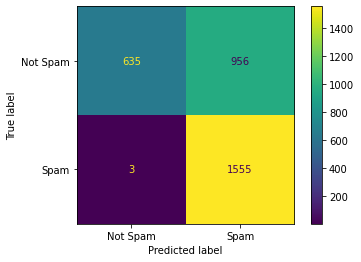

In [109]:
# Base K-Nearest Neighbors with TF-IDF vectorization
basic_p_knn_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier()),
],verbose=True)

knn_tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)
knn_X_train, knn_y_train, knn_X_val, knn_y_val, knn_X_test, knn_y_test = split(knn_tweets_df)

basic_p_knn_tfidf_m = basic_p_knn_tfidf.fit(knn_X_train, knn_y_train)
dump(basic_p_knn_tfidf_m, '../Models/Basic/p_knn_tfidf_m.joblib')
evaluation_summary("KNN TF-IDF", basic_p_knn_tfidf_m.predict(knn_X_test), knn_y_test)

### Basic KNN TF-IDF Grid Search

In [110]:
# Set parameters dictionary
knn_params = {
   'tfidf__sublinear_tf': (True, False),
   'knn__n_neighbors': ([2,5,10]),
   'knn__weights': ('uniform', 'distance')
}

basic_p_knn_tfidf_params = grid_search(basic_p_knn_tfidf, (knn_X_val, knn_y_val), knn_params)

Performing grid search...
Pipeline: ['tfidf', 'knn']
Parameters:
{'tfidf__sublinear_tf': (True, False), 'knn__n_neighbors': [2, 5, 10], 'knn__weights': ('uniform', 'distance')}
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s
Best score: 0.788
Best parameters set:
	knn__n_neighbors: 5
	knn__weights: 'distance'
	tfidf__sublinear_tf: True


### Basic KNN TF-IDF with Tuned Hyperparameters

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: KNN TF-IDF
Classifier 'KNN TF-IDF' has Acc=0.743 P=0.746 R=0.827 F1=0.727

              precision    recall  f1-score   support

       False      0.493     0.996     0.660       788
        True      0.998     0.659     0.794      2361

    accuracy                          0.743      3149
   macro avg      0.746     0.827     0.727      3149
weighted avg      0.872     0.743     0.760      3149


Confusion matrix:


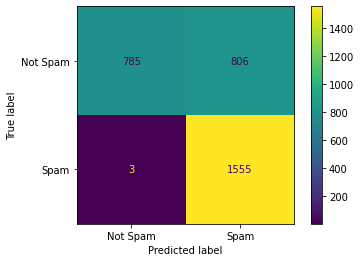

In [111]:
best_p_knn_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
],verbose=True)

final_knn_X_train = knn_X_train.append(knn_X_val)
final_knn_y_train = knn_y_train.append(knn_y_val)

best_p_knn_tfidf_m = best_p_knn_tfidf.fit(final_knn_X_train, final_knn_y_train)
dump(best_p_knn_tfidf_m, '../Models/Basic/p_knn_tfidf_m.joblib')
evaluation_summary("KNN TF-IDF", best_p_knn_tfidf_m.predict(knn_X_test), knn_y_test)

***
## SVM (Support Vector Machine)
### Basic SVM with TF-IDF vectorization

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[LibSVM][Pipeline] ............... (step 2 of 2) Processing svm, total=  52.5s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: SVM TF-IDF
Classifier 'SVM TF-IDF' has Acc=0.904 P=0.904 R=0.904 F1=0.904

              precision    recall  f1-score   support

       False      0.906     0.904     0.905      1596
        True      0.901     0.904     0.903      1553

    accuracy                          0.904      3149
   macro avg      0.904     0.904     0.904      3149
weighted avg      0.904     0.904     0.904      3149


Confusion matrix:


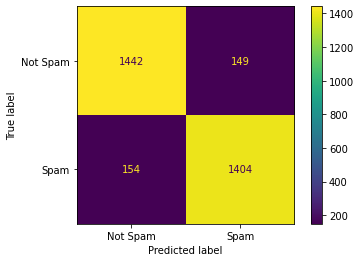

In [112]:
# Base Support Vector Machine with TF-IDF vectorization
basic_p_svm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(probability=True,verbose=True)),
],verbose=True)

svm_tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)
svm_X_train, svm_y_train, svm_X_val, svm_y_val, svm_X_test, svm_y_test = split(svm_tweets_df)

basic_p_svm_tfidf_m = basic_p_svm_tfidf.fit(svm_X_train, svm_y_train)
dump(basic_p_svm_tfidf_m, '../Models/Basic/p_svm_tfidf_m.joblib')
evaluation_summary("SVM TF-IDF", basic_p_svm_tfidf_m.predict(svm_X_test), svm_y_test)

### Basic SVM TF-IDF Grid Search

In [113]:
# Set parameters dictionary
svm_params = {
   'tfidf__sublinear_tf': (True, False),
   'svm__C': (c_values),
   'svm__kernel': ('linear', 'poly', 'rbf', 'sigmoid')
}

basic_p_svm_tfidf_params = grid_search(basic_p_svm_tfidf, (svm_X_val, svm_y_val), svm_params)

Performing grid search...
Pipeline: ['tfidf', 'svm']
Parameters:
{'tfidf__sublinear_tf': (True, False), 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 'svm__kernel': ('linear', 'poly', 'rbf', 'sigmoid')}
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[LibSVM][Pipeline] ............... (step 2 of 2) Processing svm, total=   5.5s
Best score: 0.823
Best parameters set:
	svm__C: 10
	svm__kernel: 'rbf'
	tfidf__sublinear_tf: True


### Basic SVM TF-IDF with Tuned Hyperparameters

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[LibSVM][Pipeline] ............... (step 2 of 2) Processing svm, total= 2.9min
Predictions must be a Pandas Series.

Macro-averaged evaluation for: SVM TF-IDF
Classifier 'SVM TF-IDF' has Acc=0.913 P=0.913 R=0.913 F1=0.913

              precision    recall  f1-score   support

       False      0.912     0.916     0.914      1584
        True      0.915     0.911     0.913      1565

    accuracy                          0.913      3149
   macro avg      0.913     0.913     0.913      3149
weighted avg      0.913     0.913     0.913      3149


Confusion matrix:


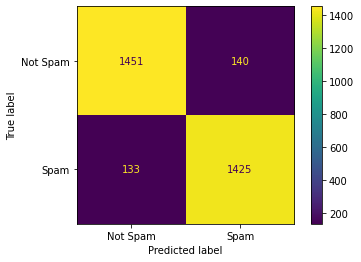

In [114]:
best_p_svm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('svm', SVC(C=10, kernel='rbf', probability=True,verbose=True)),
],verbose=True)


final_svm_X_train = svm_X_train.append(svm_X_val)
final_svm_y_train = svm_y_train.append(svm_y_val)

best_p_svm_tfidf_m = best_p_svm_tfidf.fit(final_svm_X_train, final_svm_y_train)
dump(best_p_svm_tfidf_m, '../Models/Basic/p_svm_tfidf_m.joblib')
evaluation_summary("SVM TF-IDF", best_p_svm_tfidf_m.predict(svm_X_test), svm_y_test)

***
## Multinomial Naive Bayes
### Basic MNB with TF-IDF vectorization

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing mnb, total=   0.0s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: MNB TF-IDF
Classifier 'MNB TF-IDF' has Acc=0.867 P=0.866 R=0.873 F1=0.866

              precision    recall  f1-score   support

       False      0.931     0.827     0.876      1790
        True      0.802     0.919     0.856      1359

    accuracy                          0.867      3149
   macro avg      0.866     0.873     0.866      3149
weighted avg      0.875     0.867     0.868      3149


Confusion matrix:


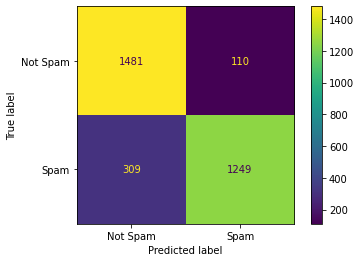

In [115]:
# Base Multinomial Naive Bayes with TF-IDF vectorization
basic_p_mnb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB()),
],verbose=True)

mnb_tweets_df = pd.concat([content_polluters_tweets_df, legitimate_users_tweets_df], axis=0)
mnb_X_train, mnb_y_train, mnb_X_val, mnb_y_val, mnb_X_test, mnb_y_test = split(mnb_tweets_df)

basic_p_mnb_tfidf_m = basic_p_mnb_tfidf.fit(mnb_X_train, mnb_y_train)
dump(basic_p_mnb_tfidf_m, '../Models/Basic/p_mnb_tfidf_m.joblib')
evaluation_summary("MNB TF-IDF", basic_p_mnb_tfidf_m.predict(mnb_X_test), mnb_y_test)

### Basic MNB TF-IDF Grid Search

In [116]:
# Set parameters dictionary
mnb_params = {
   'tfidf__sublinear_tf': (True, False),
   'mnb__fit_prior': (True, False),
   'mnb__alpha': (np.arange(0.1, 1.0, 0.1))
}

basic_p_mnb_tfidf_params = grid_search(basic_p_mnb_tfidf, (mnb_X_val, mnb_y_val), mnb_params)

Performing grid search...
Pipeline: ['tfidf', 'mnb']
Parameters:
{'tfidf__sublinear_tf': (True, False), 'mnb__fit_prior': (True, False), 'mnb__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing mnb, total=   0.0s
Best score: 0.817
Best parameters set:
	mnb__alpha: 0.1
	mnb__fit_prior: True
	tfidf__sublinear_tf: True


### Basic MNB TF-IDF with Tuned Hyperparameters

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing mnb, total=   0.0s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: MNB TF-IDF
Classifier 'MNB TF-IDF' has Acc=0.893 P=0.893 R=0.894 F1=0.893

              precision    recall  f1-score   support

       False      0.918     0.876     0.897      1666
        True      0.868     0.912     0.889      1483

    accuracy                          0.893      3149
   macro avg      0.893     0.894     0.893      3149
weighted avg      0.894     0.893     0.893      3149


Confusion matrix:


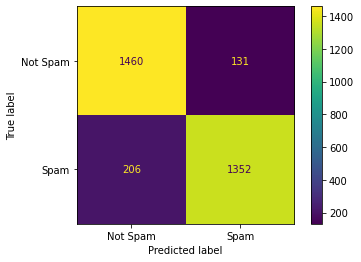

In [117]:
best_p_mnb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True)),
    ('mnb', MultinomialNB(alpha=0.1, fit_prior=True)),
],verbose=True)


final_mnb_X_train = mnb_X_train.append(mnb_X_val)
final_mnb_y_train = mnb_y_train.append(mnb_y_val)

best_p_mnb_tfidf_m = best_p_mnb_tfidf.fit(final_mnb_X_train, final_mnb_y_train)
dump(best_p_mnb_tfidf_m, '../Models/Basic/p_mnb_tfidf_m.joblib')
evaluation_summary("MNB TF-IDF", best_p_mnb_tfidf_m.predict(mnb_X_test), mnb_y_test)

***
## Decision Tree
### Basic DT with TF-IDF vectorization

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing dt, total=   0.9s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: DT TF-IDF
Classifier 'DT TF-IDF' has Acc=0.798 P=0.797 R=0.801 F1=0.797

              precision    recall  f1-score   support

       False      0.852     0.772     0.810      1755
        True      0.743     0.831     0.785      1394

    accuracy                          0.798      3149
   macro avg      0.797     0.801     0.797      3149
weighted avg      0.804     0.798     0.799      3149


Confusion matrix:


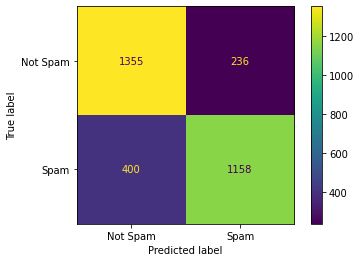

In [118]:
# Base Decision Tree with TF-IDF vectorization
basic_p_dt_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier()),
],verbose=True)

dt_tweets_df = content_polluters_tweets_df.append(legitimate_users_tweets_df, ignore_index=True)
dt_X_train, dt_y_train, dt_X_val, dt_y_val, dt_X_test, dt_y_test = split(dt_tweets_df)

basic_p_dt_tfidf_m = basic_p_dt_tfidf.fit(dt_X_train, dt_y_train)
dump(basic_p_dt_tfidf_m, '../Models/Basic/p_dt_tfidf_m.joblib')
evaluation_summary("DT TF-IDF", basic_p_dt_tfidf_m.predict(dt_X_test), dt_y_test)

### Basic DT TF-IDF Grid Search

In [119]:
# Set parameters dictionary
dt_params = {
   'tfidf__sublinear_tf': (True, False),
   'dt__criterion': ('gini', 'entropy'),
   'dt__max_features': (None, 'auto', 'sqrt', 'log2')
}

basic_p_dt_tfidf_params = grid_search(basic_p_dt_tfidf, (dt_X_val, dt_y_val), dt_params)

Performing grid search...
Pipeline: ['tfidf', 'dt']
Parameters:
{'tfidf__sublinear_tf': (True, False), 'dt__criterion': ('gini', 'entropy'), 'dt__max_features': (None, 'auto', 'sqrt', 'log2')}
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing dt, total=   0.0s
Best score: 0.720
Best parameters set:
	dt__criterion: 'gini'
	dt__max_features: 'sqrt'
	tfidf__sublinear_tf: False


### Basic DT TF-IDF with Tuned Hyperparameters

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing dt, total=   0.1s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: DT TF-IDF
Classifier 'DT TF-IDF' has Acc=0.828 P=0.828 R=0.828 F1=0.828

              precision    recall  f1-score   support

       False      0.827     0.831     0.829      1582
        True      0.829     0.824     0.826      1567

    accuracy                          0.828      3149
   macro avg      0.828     0.828     0.828      3149
weighted avg      0.828     0.828     0.828      3149


Confusion matrix:


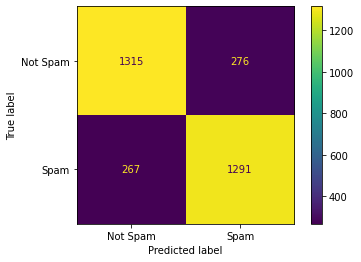

In [120]:
best_p_dt_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=False)),
    ('dt', DecisionTreeClassifier(max_features='auto', criterion='entropy')),
],verbose=True)


final_dt_X_train = dt_X_train.append(dt_X_val)
final_dt_y_train = dt_y_train.append(dt_y_val)

best_p_dt_tfidf_m = best_p_dt_tfidf.fit(final_dt_X_train, final_dt_y_train)
dump(best_p_dt_tfidf_m, '../Models/Basic/p_dt_tfidf_m.joblib')
evaluation_summary("DT TF-IDF", best_p_dt_tfidf_m.predict(dt_X_test), dt_y_test)

***
# Advanced Model
#### (SVM with TF-IDF vectorization on Tweet's text and One-Hot Vectorization on numeric metadata)

***
## Text Preprocessing and Metadata Extraction Method Definitions
>### - `break_down_tweet`(`string`):
>Splits the string into tokens using SpaCy's custom NLP tokenization. Extracts URL ,`@`s, `#`tags, emojis, numeric, and stop-word tokens. Retains and returns the normalized left-over tokens, the amount of numeric, emoji and stop-word tokens, and the lists of emoji, `@`s, and `#`tags tokens. 
***
>### - `meta_tweets`(`df`):
>Extracts the metadata of tweets in df dataframe and returns an updated dataframe including the metadata.

In [121]:
def break_down_tweet(string, normalize=True):
    tokens = []
    doc = nlp(string)
    emojis = []
    ats = []
    hashtags = []
    emoji_num = 0
    nums = 0
    stop_word_num = 0
    for token in doc:
        try:
            if not token.like_url:
                if token.prefix_ == '@':
                    ats.append(token)
                elif token.prefix_ == '#':
                    hashtags.append(token)
                elif token._.is_emoji:
                    emoji_num += 1
                    emojis.append(token)
                elif token.like_num:
                    nums += 1
                elif token.is_stop:
                    stop_word_num += 1
                else:
                    tokens.append(token)
        except Exception as e:
            print(e)
    if normalize:
        tokens = custom_normalize(tokens)
    
    return tokens, nums, emojis, emoji_num, stop_word_num, ats, hashtags

def meta_tweets(df):
    meta_df = df[0:0]
    for i in range(len(df)):
        row = df[i:i+1]
        tokens, nums, emojis, emoji_num, stop_word_num, ats, hashtags = break_down_tweet(row['Tweet'].iat[0])
        row['Tokens'] = ''.join(tokens)
        row['Numerical'] = nums
        row['Emojis'] = [emojis]
        row['Emoji count'] = emoji_num
        row['Stop-word count'] = stop_word_num
        row['@s'] = [ats]
        row['#s'] = [hashtags]
        meta_df = meta_df.append(row)
    return meta_df

>### - `adv_split`(`tweets_df`):
>Splits the dataset into `training` (`60%`), `validation` (`20%`) and `test` (`20%`) data, and returns the Tweet's metadata and label.

In [122]:
def adv_split(tweets_df):
    X_train, X_test, y_train, y_test = train_test_split(tweets_df, tweets_df['Spam'], test_size=0.2, random_state=0)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    return X_train, y_train, X_val, y_val, X_test, y_test

Create new dataframes with tweet's metadata.

In [ ]:
content_polluters_tweets_df_copy = content_polluters_tweets_df.copy()
legitimate_users_tweets_df_copy = legitimate_users_tweets_df.copy()

meta_cp_tweets_df = meta_tweets(content_polluters_tweets_df_copy)
meta_lu_tweets_df = meta_tweets(legitimate_users_tweets_df_copy)

### Advanced Model

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.1s
[LibSVM][Pipeline] ............... (step 2 of 2) Processing svm, total=  12.0s
Predictions must be a Pandas Series.

Macro-averaged evaluation for: Advanced Model with Numerical Features
Classifier 'Advanced Model with Numerical Features' has Acc=0.954 P=0.954 R=0.954 F1=0.954

              precision    recall  f1-score   support

       False      0.962     0.947     0.954      1617
        True      0.945     0.961     0.953      1532

    accuracy                          0.954      3149
   macro avg      0.954     0.954     0.954      3149
weighted avg      0.954     0.954     0.954      3149


Confusion matrix:


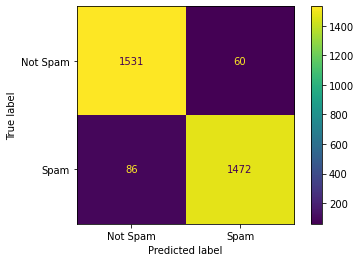

In [124]:
adv_tweets_df = meta_cp_tweets_df.append(meta_lu_tweets_df, ignore_index=True)
adv_X_train, adv_y_train, adv_X_val, adv_y_val, adv_X_test, adv_y_test = adv_split(adv_tweets_df)
adv_X_train = adv_X_train.append(adv_X_val)
adv_y_train = adv_y_train.append(adv_y_val)

numeric_features = ["NumberOfFollowers","NumberOfTweets","LengthOfScreenName","LengthOfDescriptionInUserProfile","TimeDelta(Days)","Numerical","Emoji count","Stop-word count"]

column_transformer = ColumnTransformer([
                    # TFIDF Vectorization of custom tokenized tweet
                    ("tfidf", TfidfVectorizer(sublinear_tf=True), 'Tokens'),
                    # Numeric Features
                    ('numeric', 'passthrough', numeric_features)
                    ])

adv_pipeline = Pipeline([
    ('ct', column_transformer),
    ('svm', SVC(C=10, kernel='rbf', probability=True,verbose=True)),
],verbose=True)

adv_model = adv_pipeline.fit(adv_X_train, adv_y_train)
dump(adv_model, '../Models/Advanced/advanced_model.joblib')
evaluation_summary('Advanced Model with Numerical Features', adv_pipeline.predict(adv_X_test), adv_y_test)